In [ ]:
!pip install timm tensorflow scikit-learn seaborn tf2onnx onnx onnxruntime


INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
t

In [ ]:
import os
import numpy as np
import tensorflow as tf
import timm
from tensorflow.keras import layers, Model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive to access the dataset
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Dataset path (update with your path)
DATA_ROOT = "/content/drive/MyDrive/dataset_gray_bal_2500"   # Update path here
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

# Image size for model input (160x160 works well for RT1170)
IMG_SIZE = (160, 160)
BATCH = 16
SEED = 42

# Get class names from directory structure
class_names = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
NUM_CLASSES = len(class_names)

print("Classes:", NUM_CLASSES, class_names)


Classes: 8 ['BLOCK_ETCH', 'PARTICLE', 'PO_CONTAMINATION', 'SCRATCH', 'bridge', 'clean', 'line defects', 'others']


In [ ]:
# Load train and test datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    class_names=class_names,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    class_names=class_names,
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

# Cache and prefetch datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache("/tmp/train_cache").prefetch(AUTOTUNE)
test_ds = test_ds.cache("/tmp/test_cache").prefetch(AUTOTUNE)

print("Dataset loaded:", len(train_ds), "training batches and", len(test_ds), "test batches.")


Found 2370 files belonging to 8 classes.
Found 1017 files belonging to 8 classes.
Dataset loaded: 149 training batches and 64 test batches.


In [ ]:
from tensorflow.keras import layers, models

def build_tinycnn():
    model = models.Sequential([
        layers.InputLayer(input_shape=(160, 160, 3)),  # Input layer
        layers.Conv2D(32, (3, 3), activation="relu"),  # Convolutional layers
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(NUM_CLASSES, activation="softmax")  # Output layer with softmax
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# Build the model
tinycnn_model = build_tinycnn()
tinycnn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 92416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,829,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,849,800 (45.20 MB)

 Trainable params: 11,849,800 (45.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_path = "/content/tinycnn_best.keras"
cbs = [
    ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
]

# Train TinyCNN model
history = tinycnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cbs,
    verbose=1
)

print("Best TinyCNN model saved:", checkpoint_path)

Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3624 - loss: 146.5227
Epoch 1: val_accuracy improved from -inf to 0.36087, saving model to /content/tinycnn_best.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 491s 3s/step - accuracy: 0.3628 - loss: 145.7935 - val_accuracy: 0.3609 - val_loss: 1.2180 - learning_rate: 0.0010
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.5536 - loss: 1.2147
Epoch 2: val_accuracy improved from 0.36087 to 0.56441, saving model to /content/tinycnn_best.keras
149/149 ━━━━━━━━━━━━━━━━━━━━ 133s 896ms/step - accuracy: 0.5538 - loss: 1.2140 - val_accuracy: 0.5644 - val_loss: 1.0795 - learning_rate: 0.0010
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.6323 - loss: 1.0044
Epoch 3: val_accuracy did not improve from 0.56441
149/149 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.6322 - loss: 1.0046 - val_accuracy: 0.5457 - val_loss: 1.1201 - learning_rate: 0.0010
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - ac

64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 305ms/step


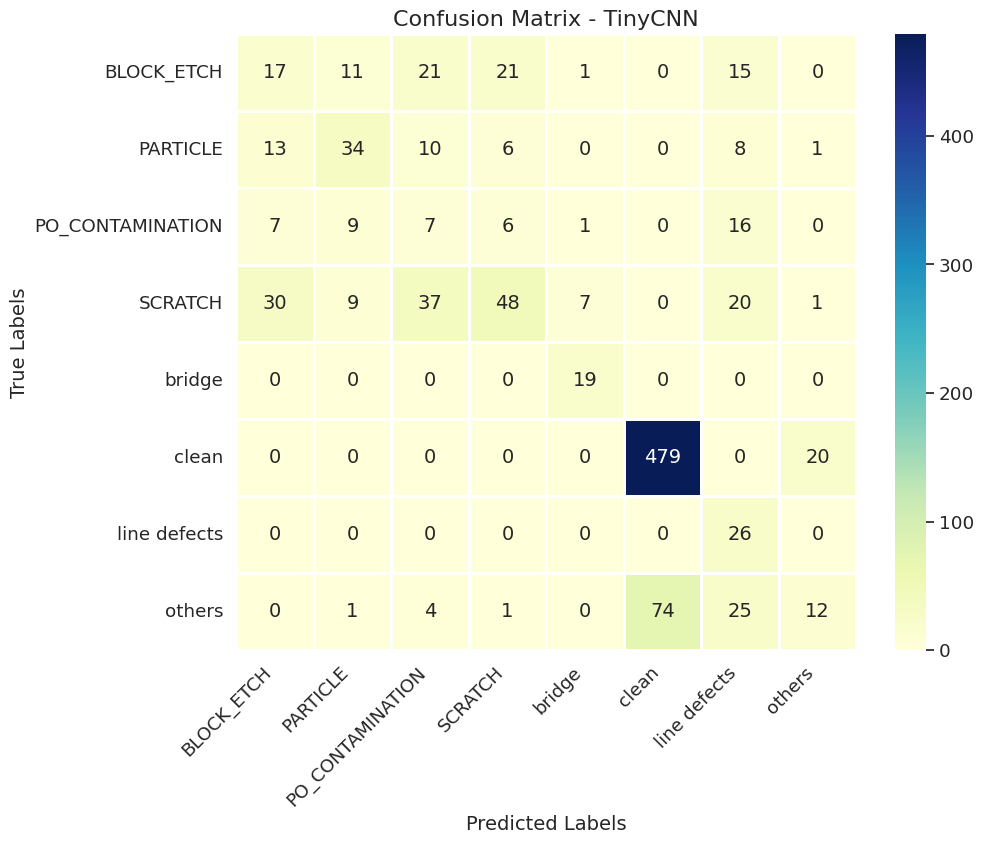

Classification Report:
                   precision    recall  f1-score   support

      BLOCK_ETCH     0.2537    0.1977    0.2222        86
        PARTICLE     0.5312    0.4722    0.5000        72
PO_CONTAMINATION     0.0886    0.1522    0.1120        46
         SCRATCH     0.5854    0.3158    0.4103       152
          bridge     0.6786    1.0000    0.8085        19
           clean     0.8662    0.9599    0.9106       499
    line defects     0.2364    1.0000    0.3824        26
          others     0.3529    0.1026    0.1589       117

        accuracy                         0.6313      1017
       macro avg     0.4491    0.5250    0.4381      1017
    weighted avg     0.6349    0.6313    0.6106      1017



In [ ]:
# Load the best saved model
best_tinycnn_model = tf.keras.models.load_model(checkpoint_path, compile=False)

# Get true and predicted labels
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred_prob = best_tinycnn_model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# Confusion Matrix Visualization
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap='YlGnBu', cbar=True, annot_kws={"size": 14},
            xticklabels=class_names, yticklabels=class_names, linewidths=1, linecolor='white')
plt.title('Confusion Matrix - TinyCNN', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=4))


In [ ]:
import tf2onnx
import tensorflow as tf
import os
import shutil

ONNX_PATH = "/content/tinycnn_rt1170_160.onnx"
spec = (tf.TensorSpec((1, 160, 160, 3), tf.float32, name="input"),)

# Ensure the model is built before conversion
# Create a dummy input tensor with the correct shape
dummy_input = tf.random.normal((1, 160, 160, 3))

# Perform a dummy call to build the model's graph
best_tinycnn_model(dummy_input)

# Now the model's output is properly defined, extract the output name
output_name = best_tinycnn_model.output.name.split(':')[0]

# Convert the model to ONNX format
model_proto, _ = tf2onnx.convert.from_keras(
    best_tinycnn_model,
    input_signature=spec,
    opset=13,
    output_path=ONNX_PATH,
)

print("✅ ONNX saved:", ONNX_PATH)
print("Size MB:", os.path.getsize(ONNX_PATH) / 1024 / 1024)

# Optional: Clean up temporary directories if you created any (not needed in this case)
# shutil.rmtree(temp_saved_model_path)

AttributeError: The layer sequential has never been called and thus has no defined output.

In [ ]:
from google.colab import files
files.download(ONNX_PATH)
